# 群落生物多样性指数计算

总体目标：
1. 计算物种多样性，比较分析各个多样性指数大小，对比各个群落多样性
2. 分析使用不同变量（四度一量）计算的多样性值的差异；
3. 分析各个地点的植物组成的生活型谱；
4. 对比分析各地点群落结构和生产力的动态变化，以及物种多样性与生产力关系
5. 撰写给定数据的群落多样性分析报告（使用图表）。

说明：多样性指数包括α多样性（计算地点、月份），β多样性(计算一个地点月份间、地点间)，以及不同地点间群落相似性。

结果包括：α多样性，β多样性，群落相似性，不同变量计算的多样性值/指数对比分析，动态变化，生活型谱，多样性与生产力关系


任务拆解：
- 提取数据，从原表格（六个群落，每个群落六个月，包含土壤数据）提取出每一个子表（暂时去除土壤数据后，某群落的某个月物种数据）
- 计算多样性指数，对每一个子表，进行α多样性的计算
- 计算多样性指数，对同一地点不同月份之间进行β多样性分析，计算群落相似度
- 动态变化，将某一群落六个月内的多样性变化进行汇总，绘制一张图表分析物种多样性随月份的动态变化
- 对每个群落进行生活型谱分析
- 计算生物多样性和生产力之间的关系

In [4]:
from openpyxl import load_workbook  
import numpy as np 
import pandas as pd  

In [5]:
# pd.set_option('display.precision', 2)  
"""
伏笔，不要用上面这行
因为就算设置了两位小数，也无法阻止pandas对于过大/过小的数进行科学计数法表示的行为
可以直接针对dataframe/series中的数据进行格式化，将所有dataframe/series中的浮点数显示到小数点后两位
两者都是全局设置，运行一次即可
"""
pd.set_option('display.float_format', '{:.2f}'.format)  # 强制所有浮点数显示为 2 位小数

### 提取数据
定义一个函数，实现以下目标： 
- 分割每一个子表，用子表的名字查找
- 去除土壤数据
- 识别“群落”并且进一步把子表按月拆分，最终得到一个字典，键是月份，值是月份对应的dataframe

In [7]:
def extract_monthly_species_data(file_path, group_name):  
    """  
    提取指定群落的所有月份物种数据  
    参数：  
        file_path: Excel文件路径  
        group_name: 群落名称（"刘武井群落"、"香山台地群落"等）  
    返回：  
        monthly_data: 字典，键为月份，值为对应的物种数据DataFrame  
    """  
    monthly_data = {}  

    wb = load_workbook(filename=file_path, read_only=True)  
    try:  
        # sheetnames 获取工作簿中所有工作表的名称，并储存在 sheets 列表中  
        sheets = wb.sheetnames  

        # 查找包含group_name的子表  
        sheet_name = [s for s in sheets if group_name in s]  
        if not sheet_name:  
            raise ValueError(f"未找到名为'{group_name}'的子表!")  
        ws = wb[sheet_name[0]]    
        print(sheet_name)
        
        current_month = None  
        header = []  
        species_rows = []  
        
        for row_idx, row in enumerate(ws.iter_rows(values_only=True), 1):  
            # 检测月份标题行（如："5月"）  
            if row[0] and "月" in str(row[0]):  
                # 保存前一个月份的数据（如果存在）  
                if current_month and species_rows:  
                    df = pd.DataFrame(species_rows, columns=header)  
                    df.set_index("物种名称", inplace=True)  
                    monthly_data[current_month] = df  
                    species_rows = []  
                
                current_month = row[0].strip()  
                header = []  
            
            # 定位表头行  
            if current_month and not header:  
                if "物种名称" in row:  
                    header = [cell for cell in row[:6] if cell is not None]  
            
            # 收集物种数据行，并确保不重复表头  
            if current_month and header and row_idx > 2 and any(row[:6]):  
                # 添加条件排除表头重复  
                if row[0] not in header:  # 确保不加入表头  
                    species_rows.append(row[:6])  
                    
        # 处理最后一个月份的数据  
        if current_month and species_rows:  
            df = pd.DataFrame(species_rows, columns=header)  
            df.set_index("物种名称", inplace=True)  
            monthly_data[current_month] = df  
    
    finally:  
        wb.close()  
    
    return monthly_data  



### 文件路径

In [9]:
file_path = "D:\\John\\生态学\\生物多样性指数计算\\第八章多样性指数计算作业数据.xlsx"  

### 将每一个dataframe赋值为单独变量进行运算

In [11]:
lwj_monthly_species = extract_monthly_species_data(file_path, "刘武井群落")
# pd.set_option('display.precision', 2)
"""
伏笔回收，在这个块换pd.set_option('display.precision', 2)试试看
"""
lwj_5, lwj_6, lwj_7, lwj_8, lwj_9, lwj_10 = [ 
    lwj_monthly_species['刘武井群落5月'], 
    lwj_monthly_species['刘武井群落6月'], 
    lwj_monthly_species['刘武井群落7月'], 
    lwj_monthly_species['刘武井群落8月'], 
    lwj_monthly_species['刘武井群落9月'], 
    lwj_monthly_species['刘武井群落10月']
]
lwj_5.head()

['刘武井群落']


,高度(cm),频度(个),多度(个/m2),盖度(%),干重(g/m2)
物种名称,,,,,
短花针茅,5.78,10,37.33,11.80,6.93
梯牧草,2.73,8,29.33,7.00,4.33
蚓果芥,4.12,9,21.33,0.55,1.30
柠条锦鸡儿,62.00,0,0.67,4.10,0.00
小叶锦鸡儿,45.38,1,0.00,0.00,0.00


In [12]:
xstd_monthly_species = extract_monthly_species_data(file_path, "香山台地群落")
xstd_5, xstd_6, xstd_7, xstd_8, xstd_9, xstd_10 = [ 
    xstd_monthly_species['香山台地群落5月'], 
    xstd_monthly_species['香山台地群落6月'], 
    xstd_monthly_species['香山台地群落7月'], 
    xstd_monthly_species['香山台地群落8月'], 
    xstd_monthly_species['香山台地群落9月'], 
    xstd_monthly_species['香山台地群落10月']
]
xstd_5.head()

['香山台地群落']


,高度(cm),频度(个),多度(个/m2),盖度(%),干重(g/m2)
物种名称,,,,,
老瓜头,32.60,2,2.67,18.67,31.02
冷蒿,2.50,10,37.33,4.63,3.42
糙隐子草,3.76,4,13.33,0.93,1.68
荒漠锦鸡儿,28.70,3,0.00,0.00,0.00
刺叶柄棘豆,9.08,2,10.67,0.93,1.20


In [13]:
tjs_monthly_species = extract_monthly_species_data(file_path, "天井山群落")
tjs_5, tjs_6, tjs_7, tjs_8, tjs_9, tjs_10 = [ 
    tjs_monthly_species['天井山群落5月'], 
    tjs_monthly_species['天井山群落6月'], 
    tjs_monthly_species['天井山群落7月'], 
    tjs_monthly_species['天井山群落8月'], 
    tjs_monthly_species['天井山群落9月'], 
    tjs_monthly_species['天井山群落10月']
]
tjs_5.head()

['天井山群落']


,高度(cm),频度(个),多度(个/m2),盖度(%),干重(g/m2)
物种名称,,,,,
短花针茅,6.83,2,17,6.06,9.38
山杏,120.00,1,0,9.00,0.00
柠条锦鸡儿,80.00,1,2,10.00,0.00
梯牧草,9.32,9,11,3.50,3.60
糙隐子草,2.97,7,9,1.00,0.00


In [14]:
tcb_monthly_species = extract_monthly_species_data(file_path, "同场堡群落")
tcb_5, tcb_6, tcb_7, tcb_8, tcb_9, tcb_10 = [ 
    tcb_monthly_species['同场堡群落5月'], 
    tcb_monthly_species['同场堡群落6月'], 
    tcb_monthly_species['同场堡群落7月'], 
    tcb_monthly_species['同场堡群落8月'], 
    tcb_monthly_species['同场堡群落9月'], 
    tcb_monthly_species['同场堡群落10月']
]
tcb_5.head()

['同场堡群落']


,高度(cm),频度(个),多度(个/m2),盖度(%),干重(g/m2)
物种名称,,,,,
短花针茅,6.79,7,68,20.00,13.44
中亚苔草,4.78,2,128,4.00,1.96
油蒿,1.97,7,88,6.00,4.33
糙隐子草,1.88,8,16,1.52,0.72
冷蒿,2.22,2,4,4.00,1.05


In [15]:
yyw_monthly_species = extract_monthly_species_data(file_path, "月牙湾群落")
yyw_5, yyw_6, yyw_7, yyw_8, yyw_9, yyw_10 = [ 
    yyw_monthly_species['月牙湾群落5月'], 
    yyw_monthly_species['月牙湾群落6月'], 
    yyw_monthly_species['月牙湾群落7月'], 
    yyw_monthly_species['月牙湾群落8月'], 
    yyw_monthly_species['月牙湾群落9月'], 
    yyw_monthly_species['月牙湾群落10月']
]
yyw_5.head()

['月牙湾群落']


,高度(cm),频度(个),多度(个/m2),盖度(%),干重(g/m2)
物种名称,,,,,
短花针茅,13.67,9,44,28.00,25.91
糙隐子草,0.00,7,52,12.00,2.84
川青锦鸡儿,6.35,3,4,4.00,11.51
细叶车前,3.08,5,28,0.50,5.28
阿尔泰狗哇花,4.10,1,4,0.50,1.64


In [16]:
zjq_monthly_species = extract_monthly_species_data(file_path, "朱家圈群落")
zjq_5, zjq_6, zjq_7, zjq_8, zjq_9, zjq_10 = [ 
    zjq_monthly_species['朱家圈群落5月'], 
    zjq_monthly_species['朱家圈群落6月'], 
    zjq_monthly_species['朱家圈群落7月'], 
    zjq_monthly_species['朱家圈群落8月'], 
    zjq_monthly_species['朱家圈群落9月'], 
    zjq_monthly_species['朱家圈群落10月']
]
zjq_5.head()

['朱家圈群落']


,高度(cm),频度(个),多度(个/m2),盖度(%),干重(g/m2)
物种名称,,,,,
长芒草,10.10,10,96,28.00,18.63
冰草,7.47,3,12,2.80,1.29
细颈黄芪,3.02,7,16,0.88,1.77
蚓果芥,4.47,3,8,2.78,0.60
阿尔泰狗哇花,7.77,2,4,0.50,0.34


### 至此，我们已经得到了每一个种群每一个月的物种数据
先从α多样性开始看看我们要算什么

物种丰富度：
$$ 
S = 群落中多度大于零的物种数量 
$$
相对多度：
$$ 
p_i = \frac{n_i}{N}, \quad \text{其中 } N = \sum_{j=1}^{S} n_j 
$$  
Shannon-Wiener指数：
$$ 
H' = -\sum_{i=1}^{S} p_i \ln p_i 
$$
Simpson指数：
$$ 
1 - D = 1 - \sum_{i=1}^{S} p_i^2
$$ 
Pielou均匀度指数： 
$$
J' = \begin{cases}
\displaystyle \frac{H'}{\ln S} & \text{当 } S > 1, \\
0 & \text{当 } S = 1 \text{ 或 } S = 0.
\end{cases}
$$

定义一个函数： 
- 首先传给它一个dataframe，因为后续还要根据“四度一量”中其他参数计算，所以还要传一个计算依据参数，就管它叫according_to，里面放列名
- 接着计算物种丰富度、相对多读、香农指数、辛普森指数、均匀度指数
- Pielou均匀度指数出现了对数运算，警惕除零错误

In [18]:
def calculate_alpha_diversity(df, according_to):
    """
    计算群落的α多样性指数=
    参数:
        df: 包含物种数据的DataFrame
        according_to: 用于计算多样性的列名
        
    返回:
        包含多样性指数的字典
    """
    # 检查输入数据
    if according_to not in df.columns:
        raise ValueError(f"数据框中缺少指定的多度列: {according_to}")
    
    # 过滤多度为0的物种
    df = df[df[according_to] > 0].copy()
    
    # 如果过滤后没有物种，返回0值，没出现
    # if len(df) == 0:
    #     return {
    #         '物种丰富度': 0,
    #         'Shannon-Wiener指数': 0.0,
    #         'Simpson指数': 0.0,
    #         'Pielou均匀度指数': 0.0
    #     }
    
    richness = len(df) # 物种丰富度
    total_abundance = df[according_to].sum()
    relative_abundance = df[according_to] / total_abundance # 相对多度

    # 香农，辛普森，均匀度
    shannon = -sum(relative_abundance * np.log(relative_abundance))    
    simpson = 1 - sum(relative_abundance**2)
    
    # 计算Pielou均匀度指数 (J')
    # 当richness=1时，除零错误哈哈哈哈哈哈哈哈哈哈哈哈哈哈哈哈哈哈哈
    if richness == 1:
        pielou = 0.0  
    else:
        pielou = shannon / np.log(richness)
    
    return {
        '物种丰富度': richness,
        'Shannon-Wiener指数': shannon,
        'Simpson指数': simpson,
        'Pielou均匀度指数': pielou
    }

In [19]:
alpha_diversity_exmaple = calculate_alpha_diversity(lwj_6, '多度(个/m2)')
alpha_diversity_exmaple

{'物种丰富度': 13,
 'Shannon-Wiener指数': 1.9121423766529908,
 'Simpson指数': 0.8043066159759533,
 'Pielou均匀度指数': 0.7454893294834437}

### 批处理：用一个字典存储不同样地不同月份间的数据

In [21]:
data_dict = {
    '刘武井群落':{5:lwj_5, 6:lwj_6, 7:lwj_7, 8:lwj_8, 9:lwj_9, 10:lwj_10},
    '香山台地群落':{5:xstd_5, 6:xstd_6, 7:xstd_7, 8:xstd_8, 9:xstd_9, 10:xstd_10},
    '天井山群落':{5:tjs_5, 6:tjs_6, 7:tjs_7, 8:tjs_8, 9:tjs_9, 10:tjs_10},
    '同场堡群落':{5:tcb_5, 6:tcb_6, 7:tcb_7, 8:tcb_8, 9:tcb_9, 10:tcb_10},
    '月牙湾群落':{5:yyw_5, 6:yyw_6, 7:yyw_7, 8:yyw_8, 9:yyw_9, 10:yyw_10},
    '朱家圈群落':{5:zjq_5, 6:zjq_6, 7:zjq_7, 8:zjq_8, 9:zjq_9, 10:zjq_10},
}

### 批处理
- 以每个样地、每个月份作为列名（其实这样的数据并不规范，注释中的才是合理的一个索引对应一个变量那种，但是合理不代表好画图）
- 向空列表中添加样地和月份
- 调用calculate_alpha_diversity函数得到alpha多样性，并将四个结果都展开

In [23]:
import pandas as pd
from itertools import product

def batch_calculate_alpha(data_dict, according_to):
    """
    批量计算所有样地和月份的α多样性
    
    参数:
        data_dict: 嵌套字典 {样地: {月份: DataFrame}}
        according_to: 用于计算的多度列名
    
    返回:
        DataFrame格式的汇总结果
    """
    results = []
    print(f'{according_to}作为计算依据')
    # 遍历所有样地和月份组合
    for site in data_dict:
        for month in data_dict[site]:
            df = data_dict[site][month]
            try:
                alpha = calculate_alpha_diversity(df, according_to)
                results.append({
                    # '样地与月份': f'{site}{month}月',
                    '样地': site,
                    '月份': month,
                    **alpha  # 展开
                })
        
            except Exception as e:
                print(f"计算失败：样地={site}, 月份={month}, 错误={str(e)}")

    # results = pd.DataFrame(results).set_index('样地与月份')
    results = pd.DataFrame(results)
    return results, according_to



In [24]:
results_df, according_to = batch_calculate_alpha(data_dict, '多度(个/m2)')
results_df.head(10)

多度(个/m2)作为计算依据


,样地,月份,物种丰富度,Shannon-Wiener指数,Simpson指数,Pielou均匀度指数
0,刘武井群落,5,10,1.61,0.76,0.70
1,刘武井群落,6,13,1.91,0.80,0.75
2,刘武井群落,7,15,2.24,0.86,0.83
3,刘武井群落,8,13,1.81,0.78,0.71
4,刘武井群落,9,17,2.13,0.81,0.75
5,刘武井群落,10,11,1.71,0.71,0.71
6,香山台地群落,5,8,1.48,0.68,0.71
7,香山台地群落,6,14,2.06,0.83,0.78
8,香山台地群落,7,10,1.51,0.67,0.65
9,香山台地群落,8,15,1.63,0.71,0.60


### 画出不同样地不同月份之间的α多样性指数

In [26]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

### 全局宋体

In [28]:
plt.rcParams['font.sans-serif'] = ['Simsun']

### 箱线图（以多度为依据）

In [30]:
def plot_alpha_diversity_boxplot(df, 
                                metric,
                                according_to, 
                                output_dir="./结果图表",
                                palette="Set3",
                                figsize=(10, 6)):
    """
    绘制不同群落的α多样性箱线图
    
    参数:
        df (DataFrame): 包含样地、月份和多样性指标的数据框
        metric (str): 要分析的指标名称，默认为"Shannon-Wiener指数"
        output_dir (str): 图片保存目录，默认为"./结果图表"
        palette (str): 颜色方案名称，默认为"Set3"
        figsize (tuple): 图片尺寸，默认为(10,6)
    """

    
    # 创建保存目录
    Path(output_dir).mkdir(parents=True, exist_ok=True)
    
    # 初始化画布
    plt.figure(figsize=figsize)
    
    # 绘制箱线图
    ax = sns.boxplot(
        x="样地",
        y=metric,
        data=df,
        palette=palette,
        hue='样地',
        width=0.6,
        linewidth=1,
        flierprops={"marker": "o", "markersize": 4},
    )
    
    # 叠加散点显示数据分布
    sns.stripplot(
        x="样地",
        y=metric,
        data=df,
        color=".25",
        size=4,
        jitter=0.2
    )
    
    # 设置标签和标题
    plt.title(f"不同群落{metric}分布(依据{according_to})", fontsize=14, pad=20)
    plt.xlabel("群落名称", fontsize=12)
    plt.ylabel(metric, fontsize=12)
    
    # 旋转x轴标签
    plt.xticks(rotation=45, ha='right')
    
    # 自动调整布局
    plt.tight_layout()
    
    # 生成文件名
    timestamp = pd.Timestamp.now().strftime("%Y%m%d_%H%M")
    filename = f"{metric}_箱线图_{timestamp}.png"
    
    # 保存图片
    plt.savefig(
        Path(output_dir) / filename,
        dpi=300,
        bbox_inches="tight"
    )
    
    plt.close()

In [31]:
# plot_alpha_diversity_boxplot(
#     df=results_df,
#     metric="物种丰富度",
#     according_to=
#     output_dir="./生态分析结果/多样性箱线图",
#     palette="Pastel1",
#     figsize=(12, 7)
# )

plot_alpha_diversity_boxplot(
    df=results_df,
    metric="Shannon-Wiener指数",
    according_to='盖度(%)',
    output_dir="./生态分析结果/多样性箱线图",
    palette="Pastel1",
    figsize=(12, 7)
)

plot_alpha_diversity_boxplot(
    df=results_df,
    according_to='盖度(%)',
    metric="Simpson指数",
    output_dir="./生态分析结果/多样性箱线图",
    palette="Pastel1",
    figsize=(12, 7)
)

# plot_alpha_diversity_boxplot(
#     df=results_df,
#     metric="Pielou均匀度指数",
#     according_to=
#     output_dir="./生态分析结果/多样性箱线图",
#     palette="Pastel1",
#     figsize=(12, 7)
# )

### β多样性

In [33]:
def load_month_data(data_dict, month):

    # 提取月份10的所有群落数据
    community_names = list(data_dict.keys())
    samples = []
    
    for community in data_dict:
        df = data_dict[community][month] 
        df.reset_index(inplace=True)
        abundance = df.set_index("物种名称")["多度(个/m2)"].to_dict()
        samples.append(abundance)
    
    # 转换为样本×物种的矩阵
    matrix = pd.DataFrame(samples, index=community_names).fillna(0)
    species_matrix = matrix.values
    
    def bray_curtis(u, v):
        # 计算分子：两样本共有物种的最小值之和
        min_sum = np.minimum(u, v).sum()
        # 计算分母：两样本总丰度之和
        total_sum = u.sum() + v.sum()
        # 避免除以零（如果两样本总丰度均为0，则相异性为0）
        return 1 - (2 * min_sum / total_sum) if total_sum != 0 else 0
    
    # 计算所有样本对的相异性矩阵
    n_samples = len(community_names)
    bc_matrix = np.zeros((n_samples, n_samples))
    
    for i in range(n_samples):
        for j in range(n_samples):
            bc_matrix[i, j] = bray_curtis(species_matrix[i], species_matrix[j])
    
    # 转换为带标签的DataFrame
    matrix = pd.DataFrame(bc_matrix, index=community_names, columns=community_names)

    return matrix

In [34]:
load_month_data(data_dict, 6)

,刘武井群落,香山台地群落,天井山群落,同场堡群落,月牙湾群落,朱家圈群落
刘武井群落,0.00,0.96,0.72,0.62,0.71,0.62
香山台地群落,0.96,0.00,0.82,0.87,0.74,0.89
天井山群落,0.72,0.82,0.00,0.82,0.84,0.91
同场堡群落,0.62,0.87,0.82,0.00,0.32,0.95
月牙湾群落,0.71,0.74,0.84,0.32,0.00,0.89
朱家圈群落,0.62,0.89,0.91,0.95,0.89,0.00


In [35]:
def plot_heatmap(matrix, title="热力图", save_path=None, figsize=(10,8), 
                cmap="YlGnBu", annot=True, fmt=".2f", dpi=300):
    """
    绘制并保存相异性矩阵热力图
    参数：
    matrix: pd.DataFrame 相异性矩阵
    title: 图片标题
    save_path: 图片保存路径（默认不保存）
    figsize: 图片尺寸
    cmap: 颜色映射
    annot: 是否显示数值
    fmt: 数值格式
    dpi: 输出分辨率
    """
    plt.figure(figsize=figsize)
    ax = sns.heatmap(
        matrix,
        annot=annot,
        cmap=cmap,
        fmt=fmt,
        linewidths=0.5,
        cbar_kws={"label": "Bray-Curtis相异性"}
    )
    ax.set_title(title)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    
    if save_path:
        dir_path = os.path.dirname(save_path)
        if dir_path and not os.path.exists(dir_path):
            os.makedirs(dir_path)
        plt.savefig(save_path, bbox_inches="tight", dpi=dpi)
        print(f"图片已保存至：{os.path.abspath(save_path)}")
    plt.show()
    plt.close()

In [36]:
def plot_clustermap(matrix, title="聚类热力图", save_path=None, 
                   figsize=(12,10), cmap="YlGnBu", annot=True, fmt=".2f", 
                   row_cluster=True, col_cluster=True, dpi=300):
    """
    绘制并保存聚类热力图
    参数：
    matrix: pd.DataFrame 相异性矩阵
    title: 图片标题
    save_path: 图片保存路径（默认不保存）
    figsize: 图片尺寸
    cmap: 颜色映射
    annot: 是否显示数值
    fmt: 数值格式
    row/col_cluster: 是否对行列聚类
    dpi: 输出分辨率
    """
    g = sns.clustermap(
        matrix,
        cmap=cmap,
        annot=annot,
        fmt=fmt,
        figsize=figsize,
        row_cluster=row_cluster,
        col_cluster=col_cluster
    )
    g.ax_heatmap.set_xlabel("")
    g.ax_heatmap.set_ylabel("")
    plt.suptitle(title, y=1.02)
    
    if save_path:
        dir_path = os.path.dirname(save_path)
        if dir_path and not os.path.exists(dir_path):
            os.makedirs(dir_path)
        g.savefig(save_path, bbox_inches="tight", dpi=dpi)
        print(f"图片已保存至：{os.path.abspath(save_path)}")
    plt.show()
    plt.close()

In [37]:
n_samples = len(data_dict.keys())  # 假设所有月份的样地数量相同  
average_matrix = np.zeros((n_samples, n_samples)) 

for month in [5, 6, 7, 8, 9, 10]:  
    matrix = load_month_data(data_dict, month)  
    average_matrix += matrix  
average_matrix /= 6  
    

图片已保存至：D:\John\生态学\生物多样性指数计算\results\heatmap.png


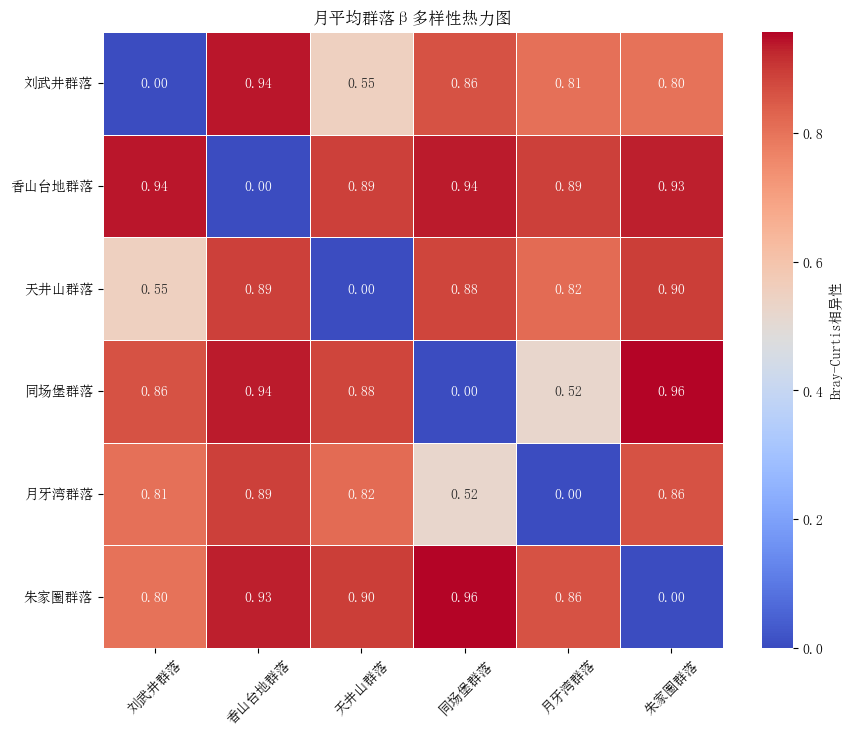

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


图片已保存至：D:\John\生态学\生物多样性指数计算\results\clustermap.pdf


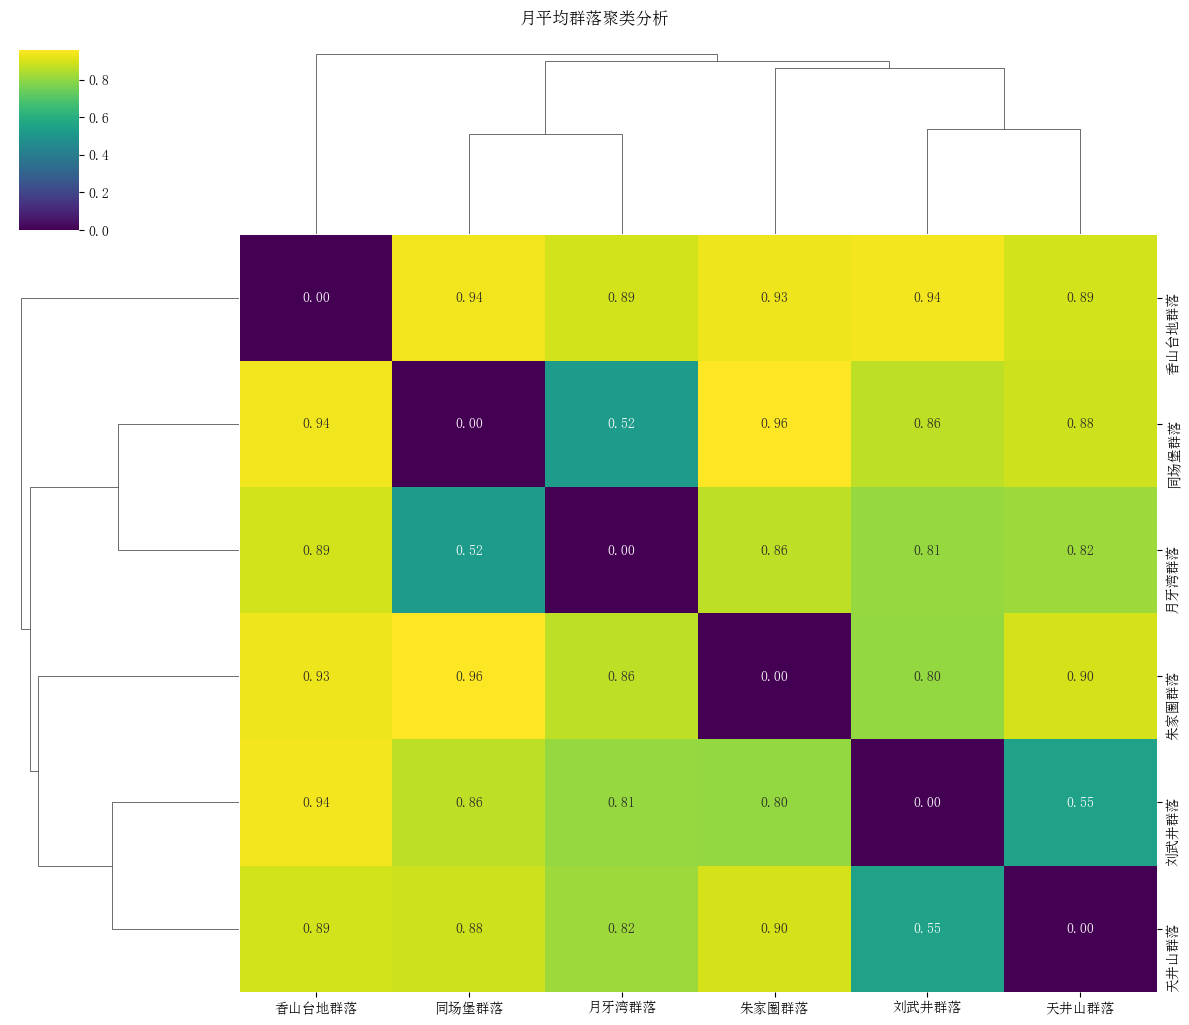

In [38]:
plot_heatmap(
    average_matrix,
    title="月平均群落β多样性热力图",
    save_path="./results/heatmap.png",  # 自动创建results目录
    cmap="coolwarm"
)

plot_clustermap(
    average_matrix,
    title="月平均群落聚类分析",
    save_path="./results/clustermap.pdf",  # 支持PDF格式
    figsize=(12,10),
    cmap="viridis"
)

In [39]:
average_matrix

,刘武井群落,香山台地群落,天井山群落,同场堡群落,月牙湾群落,朱家圈群落
刘武井群落,0.00,0.94,0.55,0.86,0.81,0.80
香山台地群落,0.94,0.00,0.89,0.94,0.89,0.93
天井山群落,0.55,0.89,0.00,0.88,0.82,0.90
同场堡群落,0.86,0.94,0.88,0.00,0.52,0.96
月牙湾群落,0.81,0.89,0.82,0.52,0.00,0.86
朱家圈群落,0.80,0.93,0.90,0.96,0.86,0.00


### 生活型谱

In [41]:
def classify_life_form(height):
    if height >= 5:
        return "乔木"
    elif 1 <= height < 5:
        return "灌木"
    else:
        return "草本"

life_form_spectrum = {}
for community, monthly_data in data_dict.items():
    life_form_spectrum[community] = {}
    for month, df in monthly_data.items():
        # 添加生活型列（假设DataFrame有"高度(cm)"列）
        df_temp = df.copy()
        df_temp["生活型"] = df_temp["高度(cm)"].apply(classify_life_form)
        # 按生活型聚合（例如计算多度总和）
        grouped = df_temp.groupby("生活型")["多度(个/m2)"].sum().to_dict()
        # 计算比例
        total = sum(grouped.values())
        spectrum = {k: v / total for k, v in grouped.items()}
        life_form_spectrum[community][month] = spectrum

life_form_spectrum

{'刘武井群落': {5: {'乔木': 0.3392958123753683,
   '灌木': 0.5238251138426738,
   '草本': 0.1368790737819578},
  6: {'乔木': 0.8802588996763755,
   '灌木': 0.07443365695792879,
   '草本': 0.04530744336569579},
  7: {'乔木': 0.8888888888888888,
   '灌木': 0.022222222222222223,
   '草本': 0.08888888888888889},
  8: {'乔木': 0.6868381240544629,
   '灌木': 0.2899646999495713,
   '草本': 0.023197175995965706},
  9: {'乔木': 0.9101654846335697,
   '灌木': 0.07801418439716312,
   '草本': 0.01182033096926714},
  10: {'乔木': 0.6000000000000001, '灌木': 0.4, '草本': 0.0}},
 '香山台地群落': {5: {'乔木': 0.19999999999999996,
   '灌木': 0.6909090909090909,
   '草本': 0.10909090909090907},
  6: {'乔木': 0.09036144578313253,
   '灌木': 0.6867469879518072,
   '草本': 0.22289156626506024},
  7: {'乔木': 0.8130563798219584, '草本': 0.18694362017804156},
  8: {'乔木': 0.6604182938470885,
   '灌木': 0.2269374294888484,
   '草本': 0.11264427666406318},
  9: {'乔木': 0.5691056910569106,
   '灌木': 0.3414634146341463,
   '草本': 0.08943089430894309},
  10: {'乔木': 0.156521739130434

In [42]:
import matplotlib.pyplot as plt
import pandas as pd

# 假设 life_form_spectrum 是已生成的生活型谱字典
def plot_lifeform_charts(life_form_spectrum, save_path="./"):
    # 定义标准生活型顺序和颜色
    life_forms = ['乔木', '灌木', '草本']
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
    # 遍历每个群落
    for community, monthly_data in life_form_spectrum.items():
        # 创建DataFrame
        data = []
        months = sorted(monthly_data.keys())  # 确保月份顺序正确
        
        for month in months:
            # 确保所有生活型都有值，缺失的补0
            row = {'月份': month}
            for lf in life_forms:
                row[lf] = monthly_data[month].get(lf, 0)
            data.append(row)
        
        df = pd.DataFrame(data).set_index('月份')
        
        # 创建画布
        fig, ax = plt.subplots(figsize=(10, 6))
        
        # 绘制堆叠柱状图
        df[life_forms].plot(
            kind='bar',
            stacked=True,
            ax=ax,
            color=colors,
            width=0.7
        )
        
        # 设置图表属性
        ax.set_title(f'{community} 生活型谱月变化', fontsize=14, pad=20)
        ax.set_xlabel('月份', fontsize=12)
        ax.set_ylabel('比例', fontsize=12)
        ax.legend(title='生活型', bbox_to_anchor=(1, 1))
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        
        # 保存图片
        plt.tight_layout()
        filename = f"{community}_生活型谱.png".replace(' ', '_')
        plt.savefig(f"{save_path}/{filename}", dpi=300, bbox_inches='tight')
        plt.close()

# 调用函数（自动保存图片到当前目录）
plot_lifeform_charts(life_form_spectrum)

In [43]:
from fpdf import FPDF

def combine_to_pdf(life_form_spectrum, img_save_path="./", pdf_save_path="所有群落生活型谱.pdf"):
    pdf = FPDF()
    for community in life_form_spectrum.keys():
        # 图片文件名需与绘图函数保存的名称一致
        img_path = f"{img_save_path}/{community}_生活型谱.png".replace(' ', '_')
        pdf.add_page()
        pdf.image(img_path, x=10, y=10, w=190)  # 调整图片位置和大小
    pdf.output(pdf_save_path)

# 调用顺序：先绘图，再合并PDF
plot_lifeform_charts(life_form_spectrum)  # 生成图片
# combine_to_pdf(life_form_spectrum)        # 合并为PDF

In [44]:
import pandas as pd

def calculate_average_spectrum(life_form_spectrum):
    """计算每个群落的平均生活型比例"""
    average_spectrum = {}
    for community, monthly_data in life_form_spectrum.items():
        # 初始化累加器
        sum_dict = {'乔木': 0, '灌木': 0, '草本': 0}
        count = len(monthly_data)
        
        # 遍历所有月份累加
        for month, spectrum in monthly_data.items():
            for life_form in sum_dict.keys():
                sum_dict[life_form] += spectrum.get(life_form, 0)
        
        # 计算平均值
        avg_dict = {k: round(v/count, 3) for k, v in sum_dict.items()}
        average_spectrum[community] = avg_dict
    
    return pd.DataFrame(average_spectrum).T

# 示例调用
avg_df = calculate_average_spectrum(life_form_spectrum)
avg_df

,乔木,灌木,草本
刘武井群落,0.72,0.23,0.05
香山台地群落,0.41,0.46,0.12
天井山群落,0.69,0.21,0.11
同场堡群落,0.47,0.52,0.01
月牙湾群落,0.57,0.36,0.07
朱家圈群落,0.67,0.29,0.04


<Figure size 1200x600 with 0 Axes>

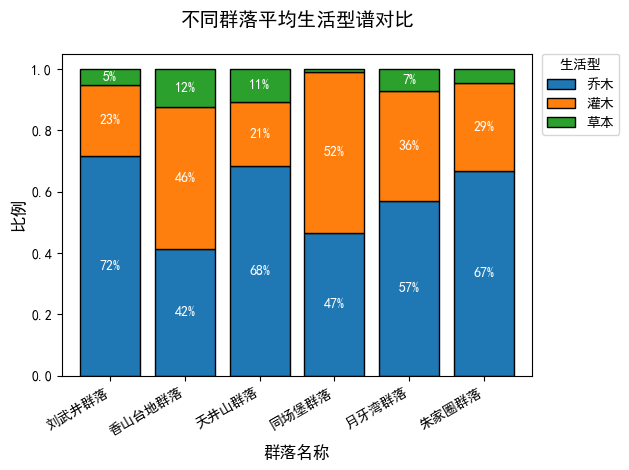

In [45]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

def plot_community_comparison(avg_df):
    # 设置中文字体（根据系统调整）
    rcParams['font.sans-serif'] = ['SimHei']  # Windows
    # rcParams['font.sans-serif'] = ['Arial Unicode MS']  # Mac
    rcParams['axes.unicode_minus'] = False
    
    # 定义颜色和参数
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    plt.figure(figsize=(12, 6))
    
    # 绘制堆叠柱状图
    ax = avg_df.plot(
        kind='bar',
        stacked=True,
        color=colors,
        width=0.8,
        edgecolor='black'
    )
    
    # 设置图表样式
    plt.title('不同群落平均生活型谱对比', fontsize=14, pad=20)
    plt.xlabel('群落名称', fontsize=12)
    plt.ylabel('比例', fontsize=12)
    plt.xticks(rotation=30, ha='right')
    plt.ylim(0, 1.05)
    
    # 添加数据标签
    for rect in ax.patches:
        height = rect.get_height()
        if height > 0.05:  # 只显示大于5%的标签
            ax.text(
                rect.get_x() + rect.get_width()/2,
                rect.get_y() + height/2,
                f'{height:.0%}',
                ha='center',
                va='center',
                color='white'
            )
    
    # 调整图例
    ax.legend(
        title='生活型',
        bbox_to_anchor=(1.02, 1),
        borderaxespad=0
    )
    
    plt.tight_layout()
    plt.savefig('群落对比_堆叠柱状图.png', dpi=300, bbox_inches='tight')
    plt.show()

# 执行绘图
plot_community_comparison(avg_df)

### 生产力与多样性

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

def analyze_productivity_biodiversity(data_dict):
    results = []
    
    for community, monthly_data in data_dict.items():
        for month, df in monthly_data.items():
            # 1. 计算生产力量（总干重(g/m2)）
            productivity = df["干重(g/m2)"].sum()  # 假设列名为"干重(g/m2)"
            
            # 2. 计算生物多样性指标
            # 物种丰富度（物种数量）
            species_richness = df.shape[0]
            
            # 香农多样性指数（需"多度(个/m2)"列）
            if "多度(个/m2)" in df.columns:
                proportions = df["多度(个/m2)"] / df["多度(个/m2)"].sum()
                shannon = -np.sum(proportions * np.log(proportions + 1e-10))  # 防止log(0)
            else:
                shannon = np.nan
            
            results.append({
                "群落": community,
                "月份": month,
                "生产力": productivity,
                "物种丰富度": species_richness,
                "香农指数": shannon
            })
    
    return pd.DataFrame(results)

# 执行分析
df_analysis = analyze_productivity_biodiversity(data_dict)
df_analysis.head()

,群落,月份,生产力,物种丰富度,香农指数
0,刘武井群落,5,13.14,24,1.61
1,刘武井群落,6,45.13,31,1.91
2,刘武井群落,7,31.79,25,2.24
3,刘武井群落,8,13.55,25,1.81
4,刘武井群落,9,13.71,32,2.13


C:\Users\Administrator\AppData\Local\Temp\ipykernel_13648\4180236690.py:15: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from font(s) SimHei.
  plt.savefig("生产力与多样性_散点图.png", dpi=300, bbox_inches="tight")
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from font(s) SimHei.
  fig.canvas.print_figure(bytes_io, **kw)


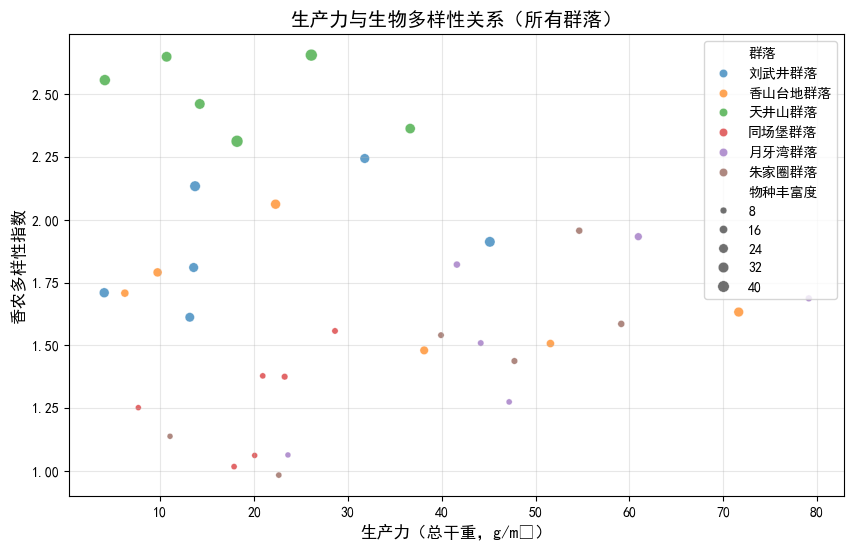

In [48]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_analysis,
    x="生产力",
    y="香农指数",
    hue="群落",
    size="物种丰富度",
    palette="tab10",
    alpha=0.7
)
plt.title("生产力与生物多样性关系（所有群落）", fontsize=14)
plt.xlabel("生产力（总干重，g/m²）", fontsize=12)
plt.ylabel("香农多样性指数", fontsize=12)
plt.grid(alpha=0.3)
plt.savefig("生产力与多样性_散点图.png", dpi=300, bbox_inches="tight")

C:\Users\Administrator\AppData\Local\Temp\ipykernel_13648\1490386060.py:61: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from font(s) SimHei.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_13648\1490386060.py:62: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from font(s) SimHei.
  plt.savefig('分群落回归分析.png', dpi=300, bbox_inches='tight')
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from font(s) SimHei.
  fig.canvas.print_figure(bytes_io, **kw)


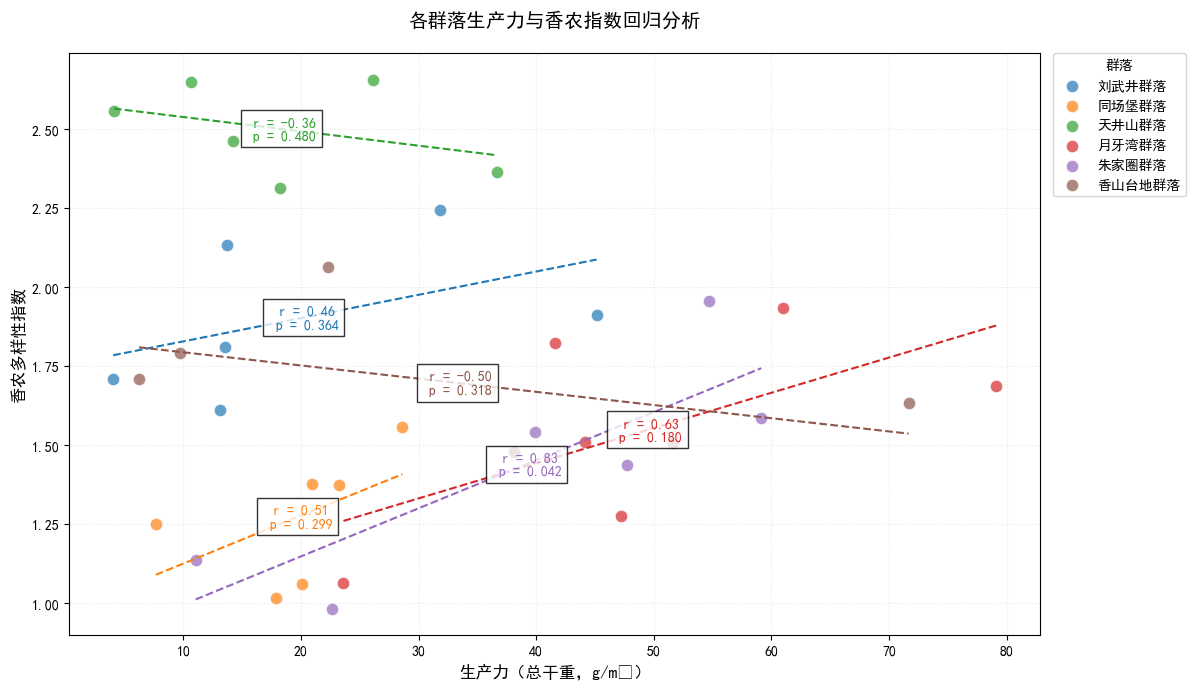

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import pearsonr

def plot_regression_with_correlation(df):
    # 设置画布
    plt.figure(figsize=(12, 7))
    palette = sns.color_palette("tab10", n_colors=len(df['群落'].unique()))
    
    # 遍历每个群落
    for i, (community, group) in enumerate(df.groupby('群落')):
        # 绘制散点
        sns.scatterplot(
            data=group,
            x='生产力',
            y='香农指数',
            color=palette[i],
            label=community,
            s=80,
            alpha=0.7
        )
        
        # 计算回归线和相关系数
        x = group['生产力'].values
        y = group['香农指数'].values
        slope, intercept = np.polyfit(x, y, 1)
        r, p = pearsonr(x, y)
        
        # 绘制回归线
        line_x = np.linspace(x.min(), x.max(), 100)
        line_y = slope * line_x + intercept
        plt.plot(line_x, line_y, 
                 color=palette[i], 
                 linestyle='--', 
                 linewidth=1.5,
                 label=f'{community}趋势线')
        
        # 添加相关系数标注
        plt.text(x=x.mean(), 
                 y=y.mean(), 
                 s=f' r = {r:.2f}\n p = {p:.3f}',
                 color=palette[i],
                 ha='center',
                 va='center',
                 bbox=dict(facecolor='white', alpha=0.8))

    # 图表装饰
    plt.title('各群落生产力与香农指数回归分析', fontsize=14, pad=20)
    plt.xlabel('生产力（总干重，g/m²）', fontsize=12)
    plt.ylabel('香农多样性指数', fontsize=12)
    plt.grid(alpha=0.3, linestyle=':')
    
    # 智能图例排版
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles[::2], labels[::2],  # 只显示群落名称
             title='群落',
             bbox_to_anchor=(1.15, 1), 
             borderaxespad=0)
    
    plt.tight_layout()
    plt.savefig('分群落回归分析.png', dpi=300, bbox_inches='tight')
    plt.show()

# 执行函数
plot_regression_with_correlation(df_analysis)